In [176]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import re

# 感情分析(Sentiment Analysis)
このノートでは, twitterのコーパスを用いてツイートの感情分析を行う.

## load data

In [122]:
df = pd.read_csv("tweet.csv")
df

,Topic,Sentiment,TweetId,TweetDate,TweetText
0,apple,positive,126415614616154112,Tue Oct 18 21:53:25 +0000 2011,Now all @Apple has to do is get swype on the i...
1,apple,positive,126404574230740992,Tue Oct 18 21:09:33 +0000 2011,@Apple will be adding more carrier support to ...
2,apple,positive,126402758403305474,Tue Oct 18 21:02:20 +0000 2011,Hilarious @youtube video - guy does a duet wit...
3,apple,positive,126397179614068736,Tue Oct 18 20:40:10 +0000 2011,@RIM you made it too easy for me to switch to ...
4,apple,positive,126395626979196928,Tue Oct 18 20:34:00 +0000 2011,I just realized that the reason I got into twi...
...,...,...,...,...,...
5108,twitter,irrelevant,126855687060987904,Thu Oct 20 03:02:07 +0000 2011,me re copè con #twitter
5109,twitter,irrelevant,126855171702661120,Thu Oct 20 03:00:04 +0000 2011,Buenas noches genteeee :) #twitter los quieroo...
5110,twitter,irrelevant,126854999442587648,Thu Oct 20 02:59:23 +0000 2011,#twitter tiene la mala costumbre de ponerce bn...
5111,twitter,irrelevant,126854818101858304,Thu Oct 20 02:58:40 +0000 2011,Oi @flaviasansi. Muito bem vinda ao meu #Twitt...


ターゲットのラベル
- positive : ポジティブ
- negative : ネガティブ
- neutral : 感情なし
- irrelevant : 意見なし

In [42]:
df["Sentiment"].value_counts()

neutral       2333
irrelevant    1689
negative       572
positive       519
Name: Sentiment, dtype: int64

## preprocessing

In [75]:
# Sentimentがpositive,negativeのツイートのみ取得
df["Sentiment"] = df["Sentiment"].str.replace("neutral","other")
df["Sentiment"] = df["Sentiment"].str.replace("irrelevant","other")
df = df[df["Sentiment"]!="other"] # otherを削除
df["one_hot_Sentiment"] = pd.get_dummies(df["Sentiment"],drop_first=True)
X = df["TweetText"]
y = df["one_hot_Sentiment"]
X = X.to_numpy()
y = y.to_numpy()

<ipython-input-75-683db3964578>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["one_hot_Sentiment"] = pd.get_dummies(df["Sentiment"],drop_first=True)


## 分類器の生成

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import precision_recall_curve,auc

In [120]:
def create_ngram_model():
    """Tf-Idfとナイーブベイズ分類器のPipeline"""
    tfidf_ngrams = TfidfVectorizer(ngram_range=(1,3),analyzer="word",binary=False)
    clf = MultinomialNB()
    pipeline = Pipeline([
        ("vect",tfidf_ngrams),
        ("clf",clf)
    ])
    return pipeline

def train_model(clf_factory,X,y):
    cv = ShuffleSplit(n_splits=10,test_size=0.3,random_state=0)
    row_num_list = list(range(len(y)))
    scores=[]
    pr_scores=[]
    
    plt.figure(facecolor="white",figsize=(10,24))
    i=1
    for train,test in cv.split(row_num_list,y):
        X_train_cv,y_train_cv = X[train],y[train]
        X_test_cv,y_test_cv = X[test],y[test]
        
        clf = clf_factory()
        clf.fit(X_train_cv,y_train_cv)
        train_score = clf.score(X_train_cv,y_train_cv)
        test_score = clf.score(X_test_cv,y_test_cv)
        scores.append(test_score)
        proba = clf.predict_proba(X_test_cv)
        
        precision,recall,pr_thresholds = precision_recall_curve(y_test_cv,proba[:,1])
        pr_scores.append(auc(recall,precision))
        
        # PR曲線を描画
        plt.subplot(5,2,i)
        plt.plot(recall, precision)
        plt.title('PR curve (cv='+str(i)+')')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.xlim(0,1)
        plt.ylim(0,1)
        i+=1
    
    plt.show()
    summary = (np.mean(scores),np.std(scores),np.mean(pr_scores),np.std(pr_scores))
    print("%.3f\t%.3f\t%.3f\t%.3f"%summary)

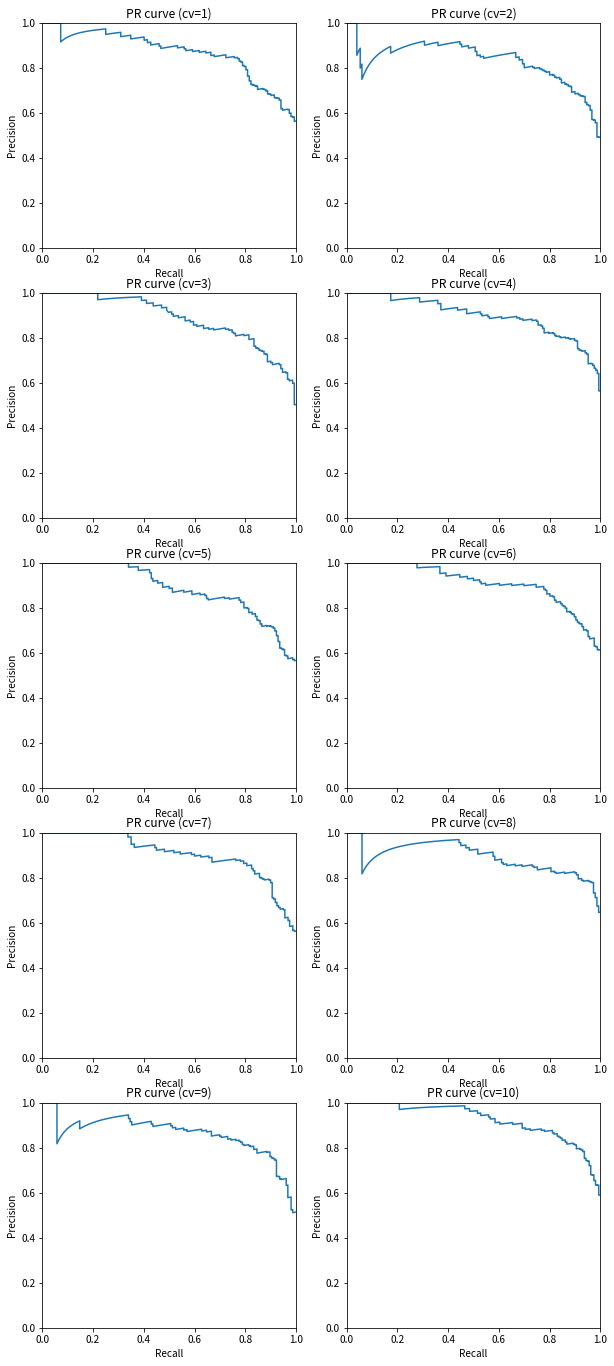

0.800	0.021	0.887	0.025


In [121]:
train_model(create_ngram_model,X,y)

正解率80.0%, AUC88.7%のモデルが得られた.

## 感情の有無を判定する分類器の作成

In [128]:
# data再読み込み

is_sentiment = ["pos","pos","neg","neg"]
# ターゲットを感情の有無に変更
for val,sen in zip(df["Sentiment"].unique(),is_sentiment):
    df["Sentiment"] = df["Sentiment"].str.replace(val,sen)

df["one_hot_Sentiment"] = pd.get_dummies(df["Sentiment"],drop_first=True)
X = df["TweetText"]
y = df["one_hot_Sentiment"]
X = X.to_numpy()
y = y.to_numpy()

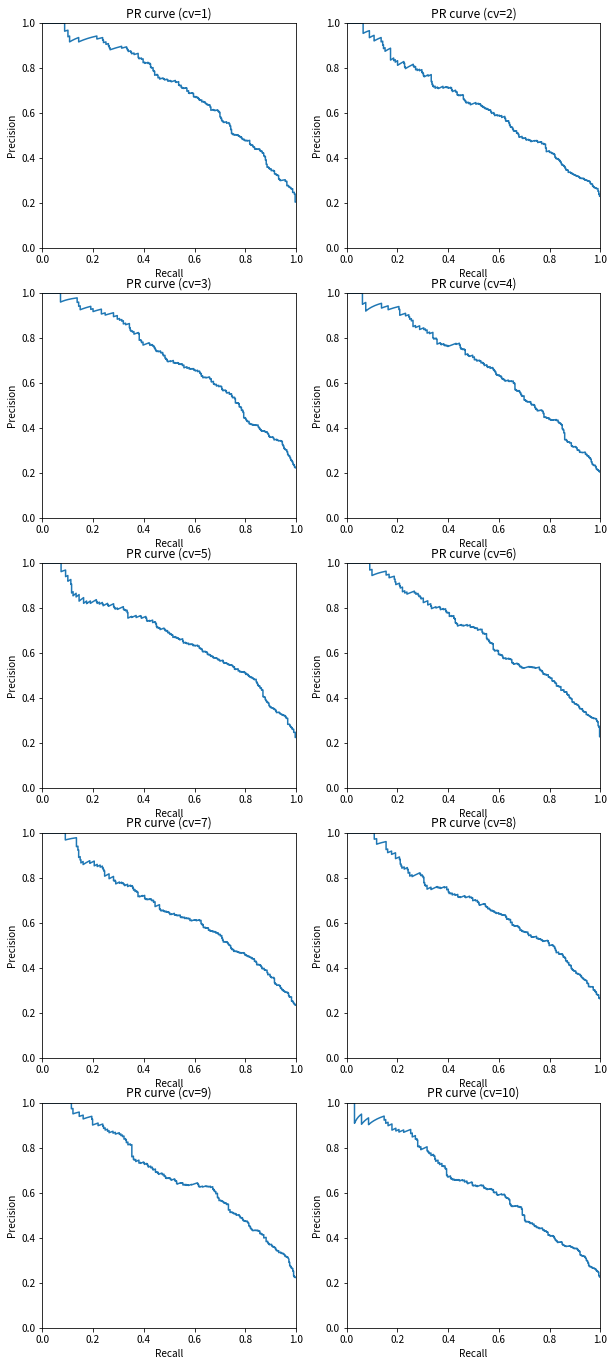

0.793	0.008	0.675	0.022


In [133]:
train_model(create_ngram_model,X,y)

AUC67.5%で低い結果となった. これは感情有のデータが全体の28%である. このためあるツイートに対して常に「感情無」という分類を行う分類器を作成しても精度が72%となってしまう. このため訓練データとテストデータの割合に気を付ける必要がある.

## GridSearch

In [134]:
from sklearn.model_selection import GridSearchCV

In [150]:
def grid_search_model(clf_factory,X,y):
    cv = ShuffleSplit(n_splits=10,test_size=0.3,random_state=0)
    params_grid = dict(vect__ngram_range=[(1, 1), (1, 2), (1, 3)], # ユニグラム, バイグラム, トリグラム
                      vect__min_df=[1, 2], # 出現頻度の低い語の除去
                      vect__stop_words=[None, "english"], # ストップワードの有無
                      vect__smooth_idf=[False, True], # 滑らかなidfを使用
                      vect__use_idf=[False, True], # idfを使用する
                      vect__sublinear_tf=[False, True],
                      vect__binary=[False, True],
                      clf__alpha=[0.01, 0.05, 0.1, 0.5, 1], # スムージング
                      )
    grid_search = GridSearchCV(clf_factory(),
                               param_grid=params_grid,
                               cv=cv,
                               scoring='f1',
                               verbose=1,
                               n_jobs=-1)
    grid_search.fit(X, y)
    clf = grid_search.best_estimator_
    print(clf)

    return clf 

In [151]:
clf = grid_search_model(create_ngram_model,X,y)
clf

Fitting 10 folds for each of 960 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 9600 out of 9600 | elapsed:  3.9min finished


Pipeline(steps=[('vect',
                 TfidfVectorizer(ngram_range=(1, 2), smooth_idf=False,
                                 use_idf=False)),
                ('clf', MultinomialNB(alpha=0.01))])


Pipeline(steps=[('vect',
                 TfidfVectorizer(ngram_range=(1, 2), smooth_idf=False,
                                 use_idf=False)),
                ('clf', MultinomialNB(alpha=0.01))])

In [163]:
def train_model(clf,X,y):
    cv = ShuffleSplit(n_splits=10,test_size=0.3,random_state=0)
    row_num_list = list(range(len(y)))
    scores=[]
    pr_scores=[]
    
    plt.figure(facecolor="white",figsize=(10,24))
    i=1
    for train,test in cv.split(row_num_list,y):
        X_train_cv,y_train_cv = X[train],y[train]
        X_test_cv,y_test_cv = X[test],y[test]
        
        clf.fit(X_train_cv,y_train_cv)
        train_score = clf.score(X_train_cv,y_train_cv)
        test_score = clf.score(X_test_cv,y_test_cv)
        scores.append(test_score)
        proba = clf.predict_proba(X_test_cv)
        
        precision,recall,pr_thresholds = precision_recall_curve(y_test_cv,proba[:,1])
        pr_scores.append(auc(recall,precision))
        
        # PR曲線を描画
        plt.subplot(5,2,i)
        plt.plot(recall, precision)
        plt.title('PR curve (cv='+str(i)+')')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.xlim(0,1)
        plt.ylim(0,1)
        i+=1
    
    plt.show()
    summary = (np.mean(scores),np.std(scores),np.mean(pr_scores),np.std(pr_scores))
    print("%.3f\t%.3f\t%.3f\t%.3f"%summary)

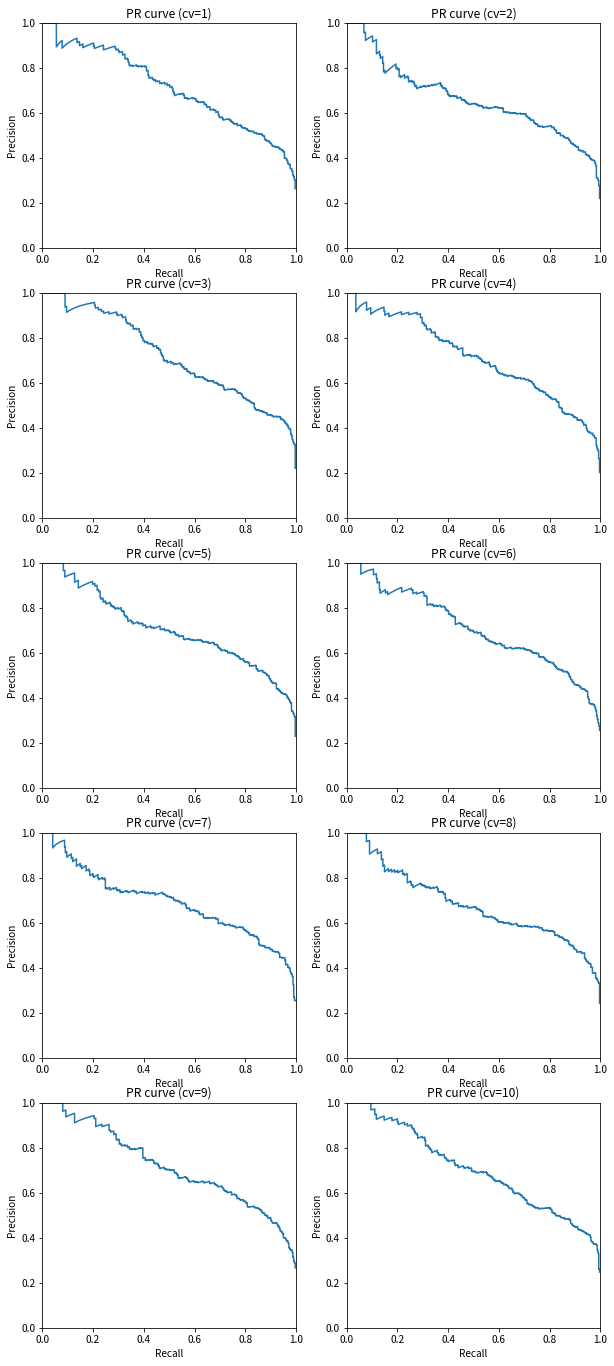

0.839	0.008	0.702	0.017


In [164]:
train_model(clf,X,y)

AUCが0.675から0.702に上昇した.

## ツイートを整形する

In [178]:
emo_repl = {
    # positive emoticons
    "&lt;3": " good ",
    ":d": " good ",  # :D in lower case
    ":dd": " good ",  # :DD in lower case
    "8)": " good ",
    ":-)": " good ",
    ":)": " good ",
    ";)": " good ",
    "(-:": " good ",
    "(:": " good ",

    # negative emoticons:
    ":/": " bad ",
    ":&gt;": " sad ",
    ":')": " sad ",
    ":-(": " bad ",
    ":(": " bad ",
    ":S": " bad ",
    ":-S": " bad ",
}

emo_repl_order = [k for (k_len, k) in reversed(
    sorted([(len(k), k) for k in emo_repl.keys()]))]

re_repl = {
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bhaha\b": "ha",
    r"\bhahaha\b": "ha",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bwon't\b": "will not",
    r"\bwouldn't\b": "would not",
    r"\bcan't\b": "can not",
    r"\bcannot\b": "can not",
}

def create_ngram_model(params=None):
    def preprocessor(tweet):
        global emoticons_replaced
        tweet = tweet.lower()

        for k in emo_repl_order:
            tweet = tweet.replace(k, emo_repl[k])
        for r, repl in re_repl.items():
            tweet = re.sub(r, repl, tweet)

        return tweet

    tfidf_ngrams = TfidfVectorizer(preprocessor=preprocessor,analyzer="word",ngram_range=(1, 2),
                                   smooth_idf=False,use_idf=False)
    clf = MultinomialNB(alpha=0.01)
    pipeline = Pipeline([('tfidf', tfidf_ngrams), ('clf', clf)])

    if params:
        pipeline.set_params(**params)

    return pipeline

In [179]:
def train_model(clf_factory,X,y):
    cv = ShuffleSplit(n_splits=10,test_size=0.3,random_state=0)
    row_num_list = list(range(len(y)))
    scores=[]
    pr_scores=[]
    
    plt.figure(facecolor="white",figsize=(10,24))
    i=1
    for train,test in cv.split(row_num_list,y):
        X_train_cv,y_train_cv = X[train],y[train]
        X_test_cv,y_test_cv = X[test],y[test]
        
        clf = clf_factory()
        clf.fit(X_train_cv,y_train_cv)
        train_score = clf.score(X_train_cv,y_train_cv)
        test_score = clf.score(X_test_cv,y_test_cv)
        scores.append(test_score)
        proba = clf.predict_proba(X_test_cv)
        
        precision,recall,pr_thresholds = precision_recall_curve(y_test_cv,proba[:,1])
        pr_scores.append(auc(recall,precision))
        
        # PR曲線を描画
        plt.subplot(5,2,i)
        plt.plot(recall, precision)
        plt.title('PR curve (cv='+str(i)+')')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.xlim(0,1)
        plt.ylim(0,1)
        i+=1
    
    plt.show()
    summary = (np.mean(scores),np.std(scores),np.mean(pr_scores),np.std(pr_scores))
    print("%.3f\t%.3f\t%.3f\t%.3f"%summary)

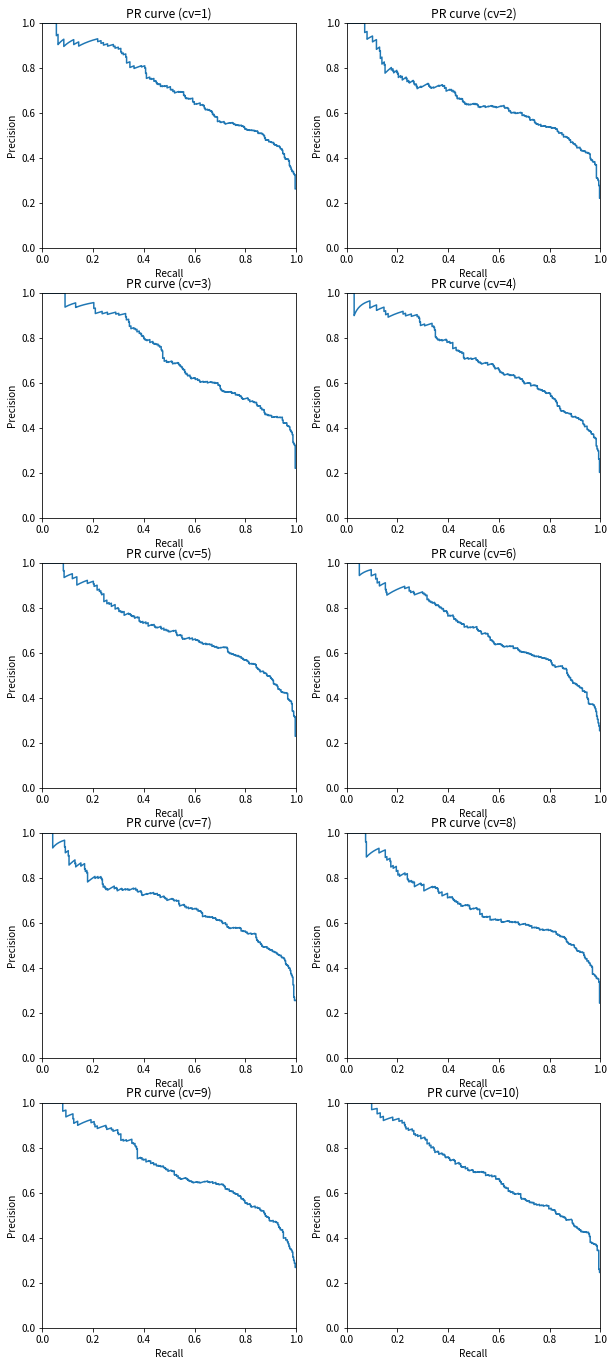

0.837	0.009	0.703	0.017


In [180]:
train_model(create_ngram_model,X,y)

## SentiWordNetの活用
SentiWordNetは英単語のポジティブ/ネガティブの度合いをスコアとして設定している.

In [205]:
import os
import collections
import csv
from sklearn.base import BaseEstimator
from sklearn.pipeline import FeatureUnion
import nltk

In [194]:
DATA_DIR = os.path.join(".", "")
def load_sent_word_net():

    sent_scores = collections.defaultdict(list)

    with open(os.path.join(DATA_DIR, "./SentiWordNet3.txt"), "r") as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='"')
        for line in reader:
            if line[0].startswith("#"):
                continue
            if len(line) == 1:
                continue

            POS, ID, PosScore, NegScore, SynsetTerms, Gloss = line
            if len(POS) == 0 or len(ID) == 0:
                continue
            # print POS,PosScore,NegScore,SynsetTerms
            for term in SynsetTerms.split(" "):
                # drop #number at the end of every term
                term = term.split("#")[0]
                term = term.replace("-", " ").replace("_", " ")
                key = "%s/%s" % (POS, term.split("#")[0])
                sent_scores[key].append((float(PosScore), float(NegScore)))
    for key, value in sent_scores.items():
        sent_scores[key] = np.mean(value, axis=0)

    return sent_scores

In [195]:
sent_word_net = load_sent_word_net()

In [208]:
class LinguisticVectorizer(BaseEstimator):

    def get_feature_names(self):
        return np.array(['sent_neut', 'sent_pos', 'sent_neg',
                         'nouns', 'adjectives', 'verbs', 'adverbs',
                         'allcaps', 'exclamation', 'question'])

    def fit(self, documents, y=None):
        return self

    def _get_sentiments(self, d):
        # http://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
        sent = tuple(nltk.word_tokenize(d))
        #if poscache is not None:
        #    if d in poscache:
        #        tagged = poscache[d]
        #    else:
        #        poscache[d] = tagged = nltk.pos_tag(sent)
        #else:
        tagged = nltk.pos_tag(sent)

        pos_vals = []
        neg_vals = []

        nouns = 0.
        adjectives = 0.
        verbs = 0.
        adverbs = 0.

        for w, t in tagged:
            p, n = 0, 0
            sent_pos_type = None
            if t.startswith("NN"):
                sent_pos_type = "n"
                nouns += 1
            elif t.startswith("JJ"):
                sent_pos_type = "a"
                adjectives += 1
            elif t.startswith("VB"):
                sent_pos_type = "v"
                verbs += 1
            elif t.startswith("RB"):
                sent_pos_type = "r"
                adverbs += 1

            if sent_pos_type is not None:
                sent_word = "%s/%s" % (sent_pos_type, w)

                if sent_word in sent_word_net:
                    p, n = sent_word_net[sent_word]

            pos_vals.append(p)
            neg_vals.append(n)

        l = len(sent)
        avg_pos_val = np.mean(pos_vals)
        avg_neg_val = np.mean(neg_vals)

        return [1 - avg_pos_val - avg_neg_val, avg_pos_val, avg_neg_val,
                nouns / l, adjectives / l, verbs / l, adverbs / l]

    def transform(self, documents):
        obj_val, pos_val, neg_val, nouns, adjectives, verbs, adverbs = np.array(
            [self._get_sentiments(d) for d in documents]).T

        allcaps = []
        exclamation = []
        question = []

        for d in documents:
            allcaps.append(
                np.sum([t.isupper() for t in d.split() if len(t) > 2]))

            exclamation.append(d.count("!"))
            question.append(d.count("?"))

        result = np.array(
            [obj_val, pos_val, neg_val, nouns, adjectives, verbs, adverbs, allcaps,
             exclamation, question]).T

        return result

In [216]:
def create_union_model(params=None):
    def preprocessor(tweet):
        tweet = tweet.lower()

        for k in emo_repl_order:
            tweet = tweet.replace(k, emo_repl[k])
        for r, repl in re_repl.items():
            tweet = re.sub(r, repl, tweet)

        return tweet.replace("-", " ").replace("_", " ")

    tfidf_ngrams = TfidfVectorizer(preprocessor=preprocessor,
                                   analyzer="word",ngram_range=(1, 2),
                                   smooth_idf=False,use_idf=False)
    ling_stats = LinguisticVectorizer()
    all_features = FeatureUnion(
        [('ling', ling_stats), ('tfidf', tfidf_ngrams)])
    #all_features = FeatureUnion([('tfidf', tfidf_ngrams)])
    #all_features = FeatureUnion([('ling', ling_stats)])
    clf = MultinomialNB(alpha=0.01)
    pipeline = Pipeline([('all', all_features), ('clf', clf)])

    if params:
        pipeline.set_params(**params)

    return pipeline

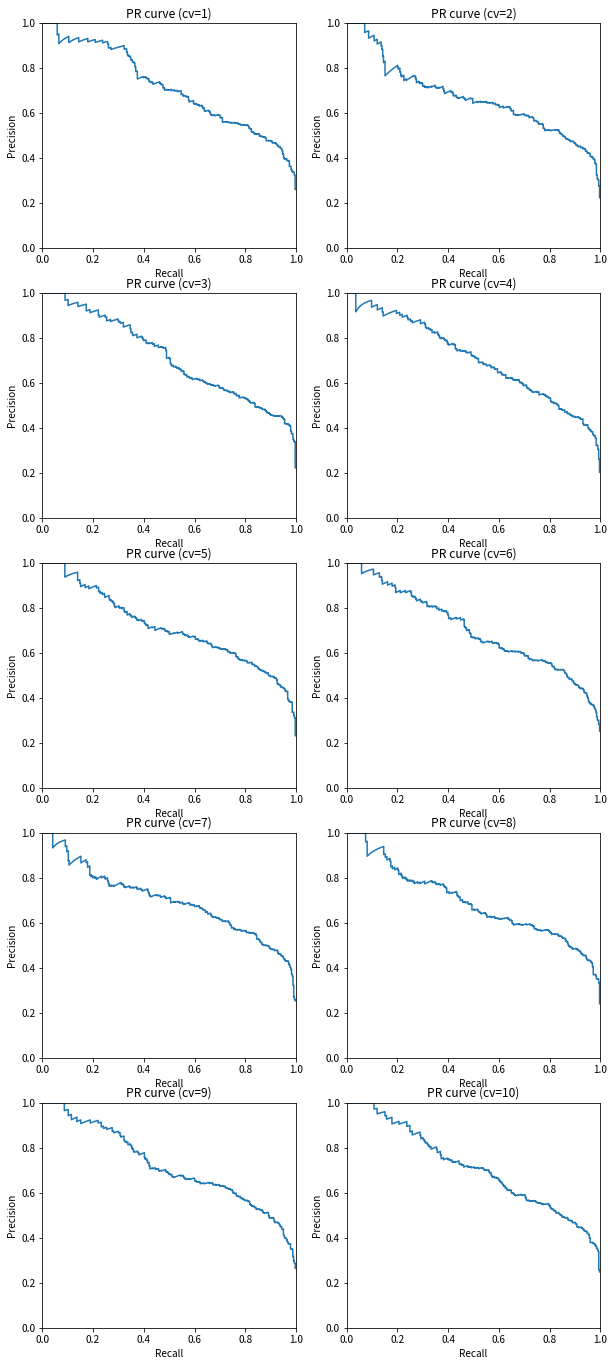

0.837	0.008	0.705	0.014


In [217]:
train_model(create_union_model,X,y)

参考書ではAUCが0.9近くまで上昇したが, SentiWordNetを導入してもわずかにAUCが上昇しただけだった. 